In [7]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, 
                                   BatchNormalization, Input, DepthwiseConv2D, 
                                   Reshape, ReLU, Add, Multiply, GlobalAveragePooling2D)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import random
import albumentations as A
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Introduce randomness
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

# === Configuration ===
config = {
    "epochs": 30,
    "is_config_batch_size_param": False, # True means use the below batch_size parameter‌ / else let the function calculate the batch size
    "batch_size": 15,
    "initial_lr": 0.001,
    "gpu_memory_limit": 48,  # in GB
    "target_size": (480, 640),  # 2:3 ratio (width, height)
    "input_shape": (640, 480, 3), # (height, width, channels) for Keras
    "data_path": "Dataset/train_images/",
    "csv_path": "processed_data/cleaned_metadata.csv", # _short is for testing only
    "train_set_csv": "Model/training6_mbnv3_rgb/training6_mbnv3_rgb_train_set.csv",
    "val_set_csv": "Model/training6_mbnv3_rgb/training6_mbnv3_rgb_validation_set.csv",
    "history_csv": "Model/training6_mbnv3_rgb/training6_mbnv3_rgb_history.csv",
    "best_model": "Model/training6_mbnv3_rgb/training6_mbnv3_rgb_best_model.keras",
    "label_encoder_path": "Model/training6_mbnv3_rgb/training6_mbnv3_rgb_label_encoder.npy",
    "color_channel": "",
    "augmentation": [
            # A.RandomRotate90(),
            # A.HorizontalFlip(),
            # A.VerticalFlip(),
            # A.Transpose(),
            # A.RandomBrightnessContrast(p=0.5),
            # A.HueSaturationValue(p=0.5),
            # A.CLAHE(p=0.5),
            A.Resize(width=480, height=640),
        ]
}



In [8]:
# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape, gpu_mem=24, default_batch=32, is_use_config_batch_size_param=config["is_config_batch_size_param"]):
    """Improved batch size calculator with error handling"""
    if is_use_config_batch_size_param:
        return default_batch
    try:
        params = model.count_params()
        
        last_dense = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                last_dense = layer
                if layer.name == 'features':  
                    break
        
        if last_dense is None:
            raise ValueError("No Dense layer found in model!")
        
        # Memory per sample = weights + activations (in GB)
        per_sample = (
            (params * 4) +                 
            (np.prod(input_shape) * last_dense.units * 4)  
        ) / (1024 ** 3)
        
        # Max batch size with 3GB safety margin
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)  
    
    except Exception as e:
        print(f"Warning: Batch size estimation failed, using default={default_batch}. Error: {e}")
        return default_batch

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le


In [9]:
# === Model Architecture ===
from tensorflow.keras.layers import Layer, Input, Conv2D, DepthwiseConv2D, Dense
from tensorflow.keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.layers import Multiply, Add, Reshape, Dropout
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="CustomLayers")
class HardSwish(Layer):
    """Custom HardSwish activation as a Keras Layer"""
    def call(self, inputs):
        return inputs * tf.nn.relu6(inputs + 3) / 6

@register_keras_serializable(package="CustomLayers")
class SEBlock(Layer):
    """Squeeze-and-Excitation block as a Keras Layer"""
    def __init__(self, reduction_ratio=0.25, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        channels = input_shape[-1]
        self.reduced_filters = max(1, int(channels * self.reduction_ratio))
        self.se_dense_reduce = Dense(self.reduced_filters, activation='relu')
        self.se_dense_expand = Dense(channels, activation='hard_sigmoid')
        super().build(input_shape)
        
    def call(self, inputs):
        se = GlobalAveragePooling2D()(inputs)
        se = self.se_dense_reduce(se)
        se = self.se_dense_expand(se)
        se = Reshape((1, 1, inputs.shape[-1]))(se)
        return Multiply()([inputs, se])
        
def create_mobilenetv3(input_shape, num_classes, model_type='small'):
    """Corrected MobileNetV3 implementation with proper Keras wrapping"""
    inputs = Input(shape=input_shape)
    
    # Initial layers
    x = Conv2D(16, (3,3), strides=(2,2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = HardSwish()(x)
    
    # Bottleneck block definition
    def bottleneck(x, out_channels, expansion, strides, kernel_size=3, se_ratio=None, use_hswish=False):
        in_channels = x.shape[-1]
        expanded_channels = int(in_channels * expansion)
        residual = x
        
        # Expansion phase
        if expansion != 1:
            x = Conv2D(expanded_channels, (1,1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = HardSwish()(x) if use_hswish else ReLU()(x)
        
        # Depthwise conv
        x = DepthwiseConv2D(
            kernel_size, 
            strides=strides, 
            padding='same', 
            use_bias=False
        )(x)
        x = BatchNormalization()(x)
        x = HardSwish()(x) if use_hswish else ReLU()(x)
        
        # SE block
        if se_ratio:
            x = SEBlock(reduction_ratio=se_ratio)(x)
        
        # Output phase
        x = Conv2D(out_channels, (1,1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        
        # Skip connection
        if strides == 1 and in_channels == out_channels:
            x = Add()([x, residual])
        
        return x
    
    # Block configurations
    if model_type == 'small':
        blocks = [
            (16, 1, 2, 3, None, False),
            (24, 4.5, 2, 3, None, False),
            (24, 3.67, 1, 3, None, False),
            (40, 4, 2, 5, 0.25, False),
            (40, 6, 1, 5, 0.25, False),
            (40, 6, 1, 5, 0.25, False),
            (48, 3, 1, 5, 0.25, True),
            (48, 3, 1, 5, 0.25, True),
            (96, 6, 2, 5, 0.25, True),
            (96, 6, 1, 5, 0.25, True),
            (96, 6, 1, 5, 0.25, True)
        ]
    else:  # large
        blocks = [
            (16, 1, 1, 3, None, False),
            (24, 4, 2, 3, None, False),
            (24, 3, 1, 3, None, False),
            (40, 3, 2, 5, 0.25, False),
            (40, 3, 1, 5, 0.25, False),
            (40, 3, 1, 5, 0.25, False),
            (80, 6, 2, 3, None, False),
            (80, 2.5, 1, 3, None, False),
            (80, 2.3, 1, 3, None, False),
            (80, 2.3, 1, 3, None, False),
            (112, 6, 1, 3, 0.25, True),
            (112, 6, 1, 3, 0.25, True),
            (160, 6, 2, 5, 0.25, True),
            (160, 6, 1, 5, 0.25, True),
            (160, 6, 1, 5, 0.25, True)
        ]
    
    # Build all blocks
    for params in blocks:
        x = bottleneck(x, *params)
    
    # Final layers
    last_conv_channels = 576 if model_type == 'small' else 960
    x = Conv2D(last_conv_channels, (1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = HardSwish()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_conv_channels))(x)
    
    # Classification head
    x = Conv2D(1280, (1,1), padding='same')(x)
    x = HardSwish()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(num_classes, (1,1), padding='same', activation='softmax')(x)
    outputs = Reshape((num_classes,))(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size={config['target_size']}, shuffle=False, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        
        self.aug = A.Compose(config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label, suffix=config["color_channel"]):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}{suffix}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

# === Training ===
def train():
    cleanup_gpu_memory()
    
    try:
        train_df, val_df, le = load_and_preprocess_data(random_state=42)
        num_classes = len(le.classes_)
        print("Classes: ", num_classes)
        
        # Create the mopdel
        input_shape = config["input_shape"] 
        model = create_mobilenetv3(input_shape, num_classes)
        
        # Find optimal batch size
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {optimized_batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        print(f"Model input shape: {model.input_shape}")
        
        # Create generators for training and validation
        train_gen = RiceDataGenerator(
            df=train_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=True
        )
        
        val_gen = RiceDataGenerator(
            df=val_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=False
        )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        sample_batch = train_gen[0]
        print(f"Generator output shape: {sample_batch[0].shape}")
        print(f"Model input shape: {model.input_shape}")
        
        # Train
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=config["epochs"],
            callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,  # Stop if no improvement in 5 epochs
                    mode='max',
                    restore_best_weights=True  
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    config["best_model"],  
                    save_weights_only=False,
                    monitor='val_accuracy',
                    save_best_only=True # Save the best model
                ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy',
                    factor=0.5,  # Halve Learn Rate if no improvement
                    patience=3,
                    mode='max'
                )
            ]
        )
        
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--', label='Best Val Accuracy')
        plt.legend()
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

In [10]:
def evaluate_saved_model(model_path, use_val_set=True):
    """Deterministic evaluation with debug checks"""
    try:
        # Load model 
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        model = tf.keras.models.load_model(model_path, compile=False) 
            
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
            ]
        )

        eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"Evaluating on {len(eval_df)} samples")

        eval_gen = RiceDataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,  
            target_size=config["target_size"],
            shuffle=False,  
            debug=False,
        )

        # Inspect first batch
        x_test, y_test = eval_gen[0]
        print(f"\n[DEBUG] First batch - X shape: {x_test.shape}, y shape: {y_test.shape}")
        print(f"[DEBUG] Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")

        # Standard evaluation
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\n[METRICS] Evaluation Results:", results)

        # Collect all predictions
        y_true, y_pred = [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))  # Get class indices

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        assert len(y_true) == len(y_pred), "Label/prediction length mismatch!"

        # Print sample predictions
        print("\n[PREDICTION SAMPLES]")
        for i in range(min(5, len(y_true))):
            print(f"True: {le.classes_[y_true[i]]} ({y_true[i]}) | Pred: {le.classes_[y_pred[i]]} ({y_pred[i]})")

        # Confusion Matrix Analysis
        print("\n[CONFUSION MATRIX PARAMETERS]")
        print(f"- Classes: {le.classes_}")  # Class names from LabelEncoder
        print(f"- Total samples: {len(y_true)}")
        print(f"- Batch size: {optimized_batch_size} (affects matrix granularity)")
        print(f"- Most confused classes: Will be visible in plot")

        # Plot both normalized and raw counts
        plot_confusion_matrix(
            y_true, 
            y_pred, 
            classes=le.classes_,
            normalize=True,
            title='Normalized Confusion Matrix (%)'
        )

        plot_confusion_matrix(
            y_true,
            y_pred,
            classes=le.classes_,
            normalize=False,
            title='Confusion Matrix (Counts)'
        )

        # Additional metrics
        from sklearn.metrics import classification_report
        print("\n[CLASSIFICATION REPORT]")
        print(classification_report(y_true, y_pred, target_names=le.classes_))

        return results

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise
    
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    """
    Plots the confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the matrix
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Label classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']
Classes:  10



=== Training Configuration ===
Batch size: 15
Input size: (480, 640)
Classes: 10
GPU Memory: 48GB

Model input shape: (None, 640, 480, 3)


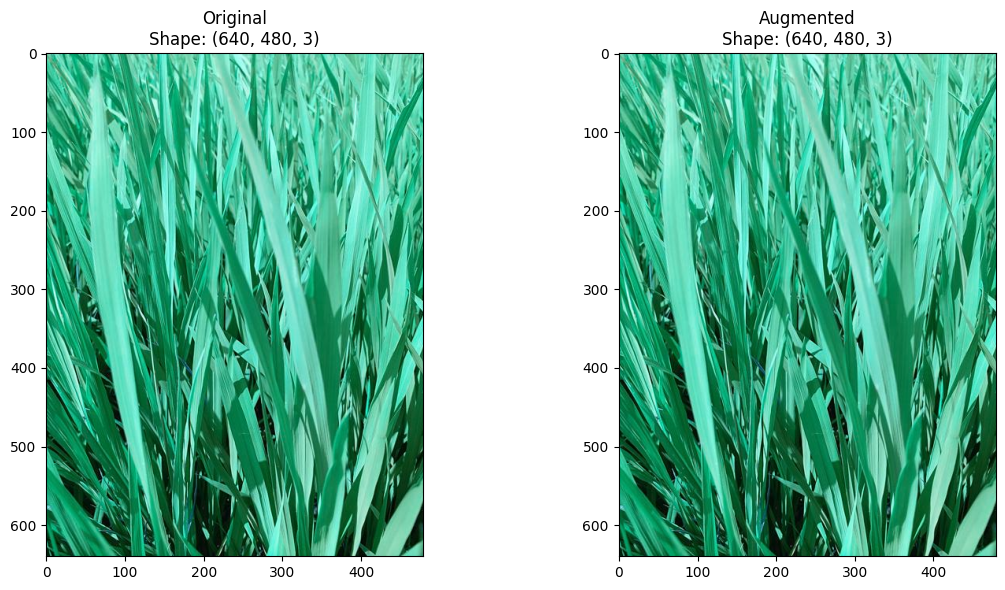

Generator output shape: (15, 640, 480, 3)
Model input shape: (None, 640, 480, 3)
Epoch 1/30


2025-05-12 11:31:15.811580: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


544/544 [==============================] - 124s 188ms/step - loss: 1.8911 - accuracy: 0.3411 - val_loss: 3.3049 - val_accuracy: 0.2004 - lr: 0.0010
Epoch 2/30
544/544 [==============================] - 105s 194ms/step - loss: 1.3075 - accuracy: 0.5589 - val_loss: 1.8385 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 3/30
544/544 [==============================] - 105s 193ms/step - loss: 1.0244 - accuracy: 0.6619 - val_loss: 1.3303 - val_accuracy: 0.5948 - lr: 0.0010
Epoch 4/30
544/544 [==============================] - 101s 186ms/step - loss: 0.8309 - accuracy: 0.7297 - val_loss: 1.1346 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 5/30
544/544 [==============================] - 102s 188ms/step - loss: 0.6566 - accuracy: 0.7880 - val_loss: 1.8945 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 6/30
544/544 [==============================] - 105s 193ms/step - loss: 0.5586 - accuracy: 0.8168 - val_loss: 1.1299 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 7/30
544/544 [==============================] - 103

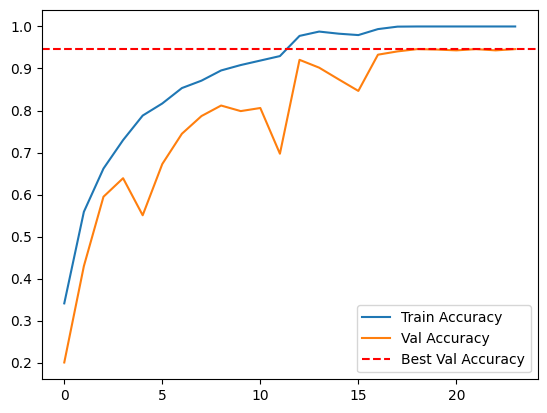

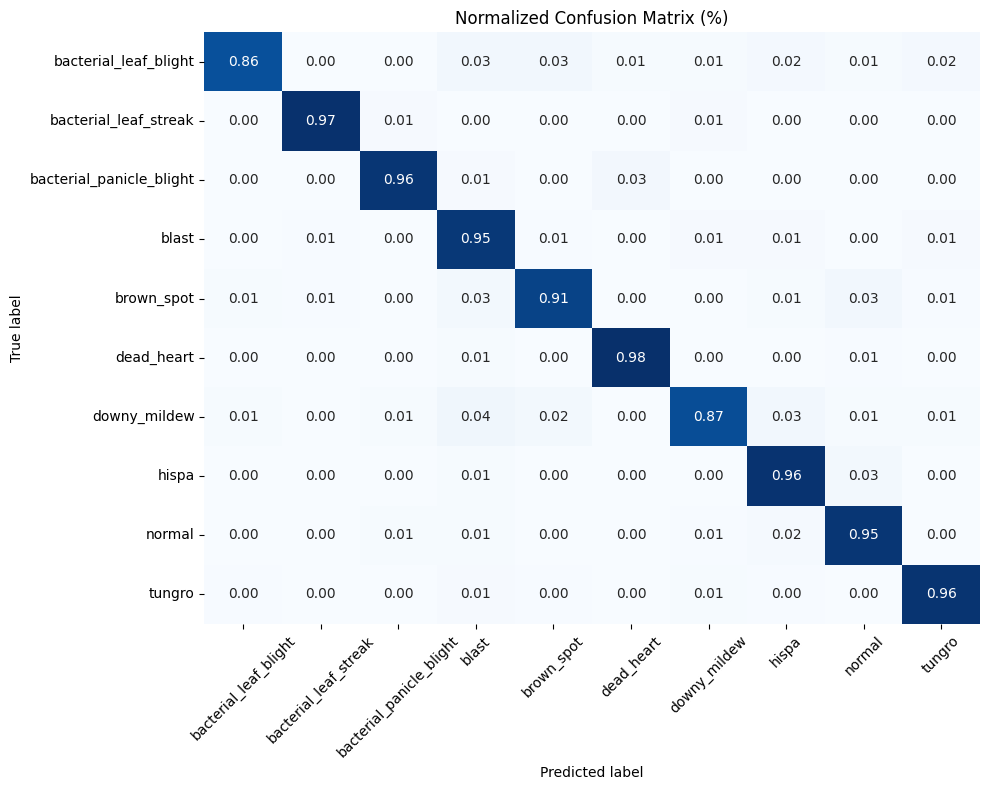

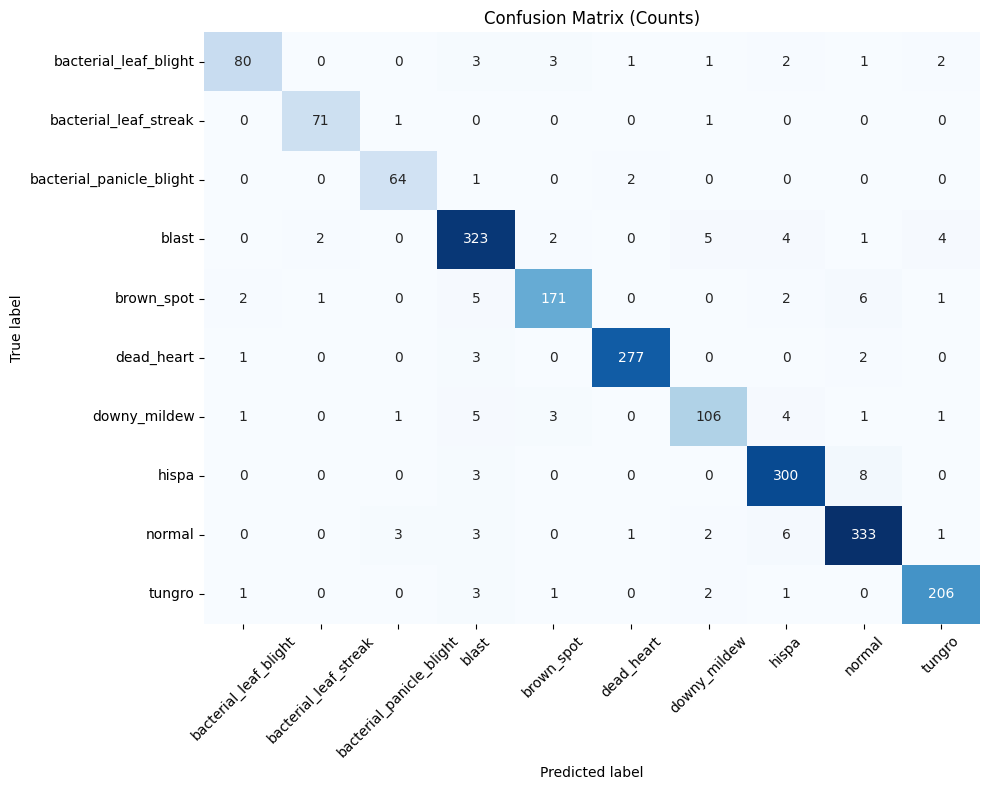


[CLASSIFICATION REPORT]
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.94      0.86      0.90        93
   bacterial_leaf_streak       0.96      0.97      0.97        73
bacterial_panicle_blight       0.93      0.96      0.94        67
                   blast       0.93      0.95      0.94       341
              brown_spot       0.95      0.91      0.93       188
              dead_heart       0.99      0.98      0.98       283
            downy_mildew       0.91      0.87      0.89       122
                   hispa       0.94      0.96      0.95       311
                  normal       0.95      0.95      0.95       349
                  tungro       0.96      0.96      0.96       214

                accuracy                           0.95      2041
               macro avg       0.94      0.94      0.94      2041
            weighted avg       0.95      0.95      0.95      2041



{'loss': 0.2899453341960907,
 'acc': 0.9461048245429993,
 'top3_acc': 0.9892209768295288}

In [11]:
# === Execution Options ===
model, model_history = train()
evaluate_saved_model(config["best_model"], use_val_set=True)